<a href="https://colab.research.google.com/github/mersalas/MLBS-2025_workshop/blob/main/Lab_3_Docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This exercise is based on [Python scripting for molecular docking workshop](https://pdb101.rcsb.org/train/training-events/python3)

In [ ]:
# Install packages
!pip install rcsb-api # searching PDB
!pip install pdb2pqr  # editing PDB
!pip install MDAnalysis # selecting atoms
!pip install rdkit #
!pip install meeko # preparing ligands for docking
!pip install vina # docking software
!pip install prolif # view interaction map
!pip install py3Dmol # view pdb

## **Docking preparation**

### Find & save protein structure

In [ ]:
from rcsbapi.search import TextQuery
from rcsbapi.search import search_attributes as attrs

ECnumber ="3.4.21.4"  # EC number of trypsin

q1 = attrs.rcsb_polymer_entity.rcsb_ec_lineage.id == ECnumber   # looking for typrins
q2 = TextQuery("13U")

query = q1 & q2   # combining the two queries

results = list(query())
print(results)

['2ZQ2']


In [ ]:
pdb_id = results[0].lower() # get the PDB ID from the list & convert it to lowercase
print(pdb_id)

2zq2


In [ ]:
import os # for making directories
import requests

# Make a directory for pdb files
protein_directory = "protein_structures"
os.makedirs(protein_directory, exist_ok=True)

# Download pdb
pbd_request = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb")
pbd_request.status_code

200

In [ ]:
# Save pdb file
with open(f"{protein_directory}/{pdb_id}.pdb", "w+") as f:
  f.write(pbd_request.text)

### Visualize protein structure

In [ ]:
import py3Dmol

# Read the PDB file content
with open(f"{protein_directory}/{pdb_id}.pdb", "r") as file:
    pdb_data = file.read()

# Create a viewer object
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, "pdb")  # Load the PDB data

# Apply styles based on residue names
view.setStyle({"resn": "13U"}, {"stick": {"colorscheme": "greenCarbon"}})  # Ligand
view.setStyle({"resn": "HOH"}, {"sphere": {"radius": 0.3, "color": "blue"}})  # Water
view.setStyle({"resn": ["ALA", "GLY", "SER", "THR", "LEU", "ILE", "VAL", "PHE", "TYR", "TRP",
                        "ASP", "GLU", "ASN", "GLN", "LYS", "ARG", "HIS", "CYS", "MET", "PRO"]},
              {"cartoon": {"color": "spectrum"}})  # Protein

view.zoomTo()  # Adjust the view to fit the molecule
view.show()  # Display the viewer

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
import MDAnalysis as mda

# Load into MDA universe
u = mda.Universe(f"{protein_directory}/{pdb_id}.pdb")
u

<Universe with 2024 atoms>

In [ ]:
# Select protein atoms
protein = u.select_atoms("protein")
protein

<AtomGroup with 1670 atoms>

In [ ]:
# Write protein to new PDB file
protein.write(f"{protein_directory}/protein_{pdb_id}.pdb")

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


### Fix protein structure

In [ ]:
! pdb2pqr --pdb-out=protein_structures/protein_h.pdb --pH=7.4 protein_structures/protein_2zq2.pdb protein_structures/protein_2zq2.pqr --whitespace

INFO:PDB2PQR v3.7.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: protein_structures/protein_2zq2.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     2>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 223 residues and 1625 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 4 missing atoms in biomolecule.
INFO:Added atom CG to residue LYS A 222 at

In [ ]:
# Make a directory for pdb files
pdbqt_directory = "pdbqt"
os.makedirs(pdbqt_directory, exist_ok=True)

# Generate pdbqt file
u = mda.Universe(f"{protein_directory}/protein_{pdb_id}.pqr")
u.atoms.write(f"{pdbqt_directory}/{pdb_id}.pdbqt")

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDBQT.py:305: UserWarning: Supplied AtomGroup was missing the following attributes: altLocs, occupancies, tempfactors. These will be written with default values. 
  warnings.warn(


In [ ]:
# Read in the just-written PDBQT file, replace text, and write back
with open(f"{pdbqt_directory}/{pdb_id}.pdbqt", 'r') as file:
  file_content = file.read()

# Replace 'TITLE' and 'CRYST1' with 'REMARK'
file_content = file_content.replace('TITLE', 'REMARK').replace('CRYST1', 'REMARK')

# Write the modified content back to the file
with open(f"{pdbqt_directory}/{pdb_id}.pdbqt", 'w') as file:
  file.write(file_content)

### **Ligand preparation**

In [ ]:
# Download the ligand
res13U_sdf = requests.get('https://files.rcsb.org/ligands/download/13U_ideal.sdf')
res13U_sdf

<Response [200]>

In [ ]:
# Make a ligands folder & save ligand
os.makedirs("ligands", exist_ok=True)

with open("ligands/13U_ideal.sdf", "w+") as file:
  file.write(res13U_sdf.text)

In [ ]:
# Read the sdf file
file = open('ligands/13U_ideal.sdf', 'r')
file_text = file.read()
print(file_text)

13U
  CCTOOLS-0919241032

 65 67  0  0  1  0  0  0  0  0999 V2000
   -1.6670    0.6990   -0.1850 C   0  0  0  0  0
   -1.0040   -0.2870    0.0570 O   0  0  0  0  0
   -3.1690    0.5990   -0.2550 C   0  0  0  0  0
   -3.5800   -0.7870    0.0040 N   0  0  0  0  0
   -5.0410   -0.9230   -0.0570 C   0  0  0  0  0
   -5.4770   -2.1230    0.7860 C   0  0  0  0  0
   -6.5540   -1.6840    1.7800 C   0  0  0  0  0
   -7.8850   -1.5120    1.0460 C   0  0  0  0  0
   -7.8620   -0.2070    0.2480 C   0  0  0  0  0
   -7.8820   -0.5230   -1.2490 C   0  0  0  0  0
   -6.9080   -1.6660   -1.5410 C   0  0  0  0  0
   -5.4740   -1.1350   -1.5090 C   0  0  0  0  0
   -1.0600    1.8850   -0.3910 N   0  0  0  0  0
    0.3970    2.1070   -0.4450 C   0  0  0  0  0
    1.0990    1.2280    0.5570 C   0  0  0  0  0
    0.5300    0.8960    1.5760 O   0  0  0  0  0
    0.5840    3.6000   -0.0780 C   0  0  0  0  0
   -0.6470    4.2470   -0.7660 C   0  0  0  0  0
   -1.7410    3.1710   -0.6000 C   0  0  0  0  0
   

[07:39:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


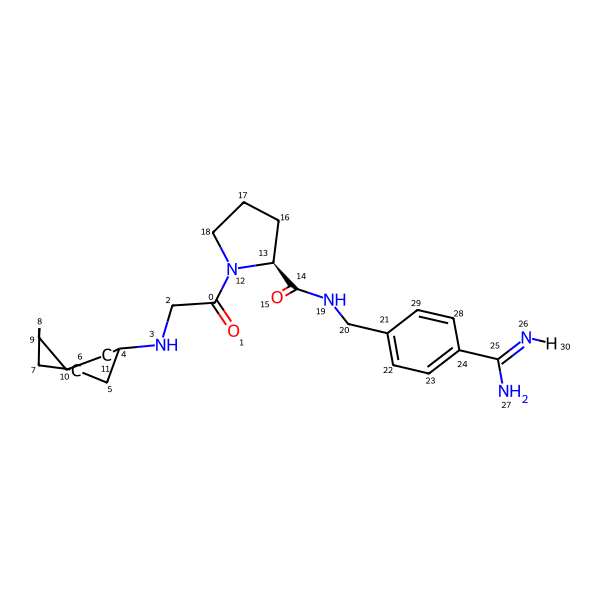

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# Configuration for displaying in Jupyter notebooks
IPythonConsole.ipython_useSVG = True  # Use SVG for higher quality images
IPythonConsole.drawOptions.addAtomIndices = True  # Show atom indices
IPythonConsole.molSize = 600,600  # Set size of image

# Show the structure of ligand
ligand = Chem.MolFromMolFile("ligands/13U_ideal.sdf")
ligand

### Modify the ligand

[07:43:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


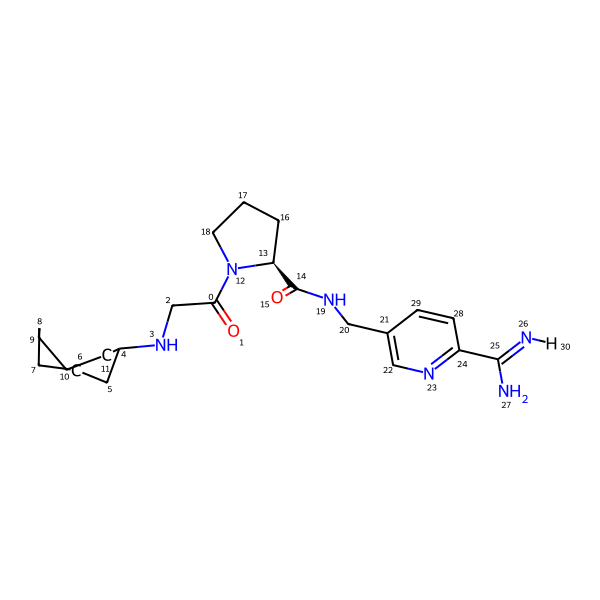

In [ ]:
# Load a duplicate copy of 13U to manipulate
mod_ligand_N = Chem.MolFromMolFile("ligands/13U_ideal.sdf")

# Change carbon in ring to a nitrogen
mod_ligand_N.GetAtomWithIdx(23).SetAtomicNum(7)

mod_ligand_N

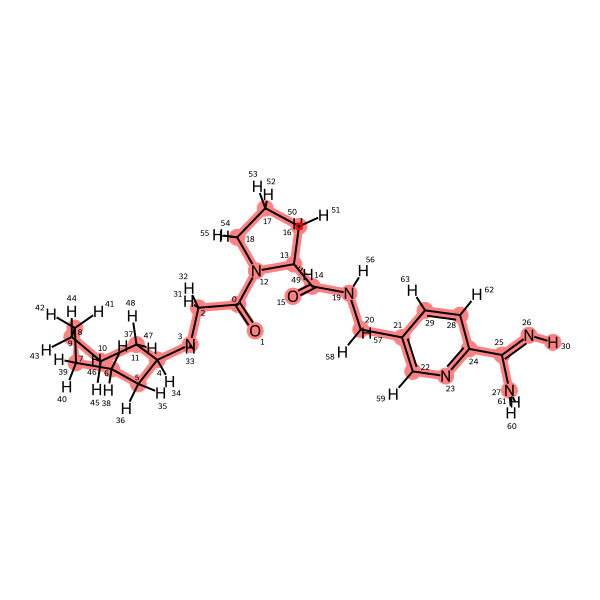

In [ ]:
# Optimize new molecules & save
from rdkit.Chem import AllChem

Chem.SanitizeMol(mod_ligand_N)
mod_ligand_NH = Chem.AddHs(mod_ligand_N)

# Do a constrained embedding to keep the ligand in the same position
# this allows for the hydrogens to be added in reasonable lcations, but keeps
# the heavy atoms in the same position
constrained_mol = AllChem.ConstrainedEmbed(mod_ligand_NH, mod_ligand_N, useTethers=True)
constrained_mol

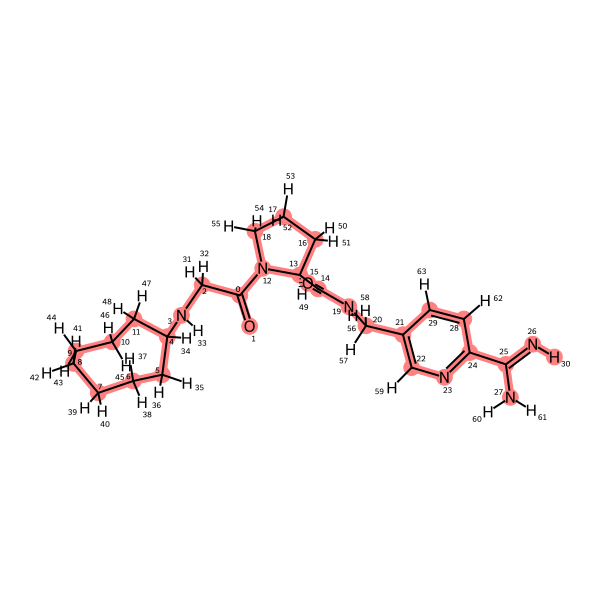

In [ ]:
# Perform geometry optimization
opt_N = AllChem.MMFFOptimizeMolecule(mod_ligand_NH)
mod_ligand_NH

In [ ]:
# Add hydrogens to 13U ligand
ligand_H = Chem.MolFromMolFile("ligands/13U_ideal.sdf", removeHs=False)

# save modified ligands as sdf files
Chem.MolToMolFile(ligand_H, 'ligands/13U.sdf')
Chem.MolToMolFile(mod_ligand_NH, 'ligands/13U_modified_N.sdf')

[08:17:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [ ]:
# Use meeko to prepare small molecules
! mk_prepare_ligand.py -i ligands/13U.sdf -o pdbqt/13U.pdbqt
! mk_prepare_ligand.py -i ligands/13U_modified_N.sdf -o pdbqt/13U_modified_N.sdf

Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


## **Docking with AutoDock Vina**

### Define ligand box

In [ ]:
# Find the center of the ligand
original_structure = mda.Universe("protein_structures/2zq2.pdb")
ligand_mda = original_structure.select_atoms("resname 13U")

# Get the center of the ligand as the pocket center
pocket_center = ligand_mda.center_of_geometry()
print(pocket_center)

[18.3068333  -8.06558332 10.638     ]


In [ ]:
# compute min & max coordinates of the ligand
# take the ligand box to be the difference between the max & min in each direction
ligand_box = ligand_mda.positions.max(axis=0) - ligand_mda.positions.min(axis=0) + 5
ligand_box

array([14.161999, 17.002   , 13.903   ], dtype=float32)

In [ ]:
# Convert to list
pocket_center = pocket_center.tolist()
ligand_box = ligand_box.tolist()

### Docking ligands

In [ ]:
# Define variables for ease
pdb_id = "2zq2"
ligand = "13U"

# Make a directory for results
os.makedirs("docking_results", exist_ok=True)

In [ ]:
from vina import Vina
v = Vina(sf_name="vina")

In [ ]:
v.set_receptor(f"pdbqt/{pdb_id}.pdbqt")
v.set_ligand_from_file(f"pdbqt/{ligand}.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)

In [ ]:
v.dock(exhaustiveness=5, n_poses=5)

In [ ]:
# Write poses to a file
v.write_poses(f"docking_results/{ligand}.pdbqt", n_poses=5, overwrite=True)

In [ ]:
# View calculated energies
v.energies()

array([[-5.0620e+00, -9.6490e+00, -4.1400e-01,  4.5870e+00, -4.1400e-01],
       [-4.9790e+00, -1.0589e+01,  6.8500e-01,  4.5110e+00, -4.1400e-01],
       [-4.7780e+00, -9.5200e+00, -1.0000e-03,  4.3290e+00, -4.1400e-01],
       [-4.5640e+00, -8.8260e+00, -2.8700e-01,  4.1350e+00, -4.1400e-01],
       [-4.5420e+00, -8.4730e+00, -6.0000e-01,  4.1160e+00, -4.1400e-01]])

In [ ]:
# Convert energies to dataframe
import pandas as pd

column_names = ["total", "inter", "intra", "torsions", "intra best pose"]

df = pd.DataFrame(v.energies(), columns=column_names)
df.head()

,total,inter,intra,torsions,intra best pose
0,-5.062,-9.649,-0.414,4.587,-0.414
1,-4.979,-10.589,0.685,4.511,-0.414
2,-4.778,-9.520,-0.001,4.329,-0.414
3,-4.564,-8.826,-0.287,4.135,-0.414
4,-4.542,-8.473,-0.600,4.116,-0.414


In [ ]:
# Save the calculated energies from docking to a CSV file
df.to_csv("docking_results/13U_energies.csv", index=False)

## **Visualize docking results**

In [ ]:
# Convert to sdf to view results
! mk_export.py docking_results/13U.pdbqt -s docking_results/13U.sdf

In [ ]:
import prolif as plf

# Load protein using RDKit
protein = Chem.MolFromPDBFile("protein_structures/protein_h.pdb", removeHs=False)

In [ ]:
# Load protein & ligands to ProLIF
protein_plf = plf.Molecule(protein)
poses_plf = plf.sdf_supplier("docking_results/13U.sdf")

In [ ]:
# Create molecular fingerprints
fp = plf.Fingerprint(count=True)

In [ ]:
# Run on your poses
fp.run_from_iterable(poses_plf, protein_plf)

  0%|          | 0/5 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7cec39189550>

In [ ]:
pose_index=1

In [ ]:
# View 2D interaction map
fp.plot_lignetwork(poses_plf[pose_index])

In [ ]:
view = fp.plot_3d(
    poses_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## **Exercise 3**

Try docking 13U_modified_N into the protein. Compare results.